In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.info()
train.describe()
print(f'Missing values are: {train.isna().sum()}')
import warnings
warnings.filterwarnings('ignore')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Count'>

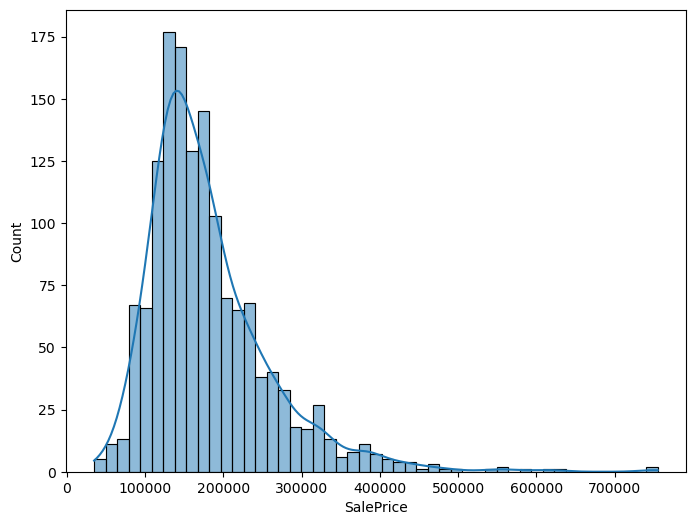

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,6))
sns.histplot(train['SalePrice'],kde = True)

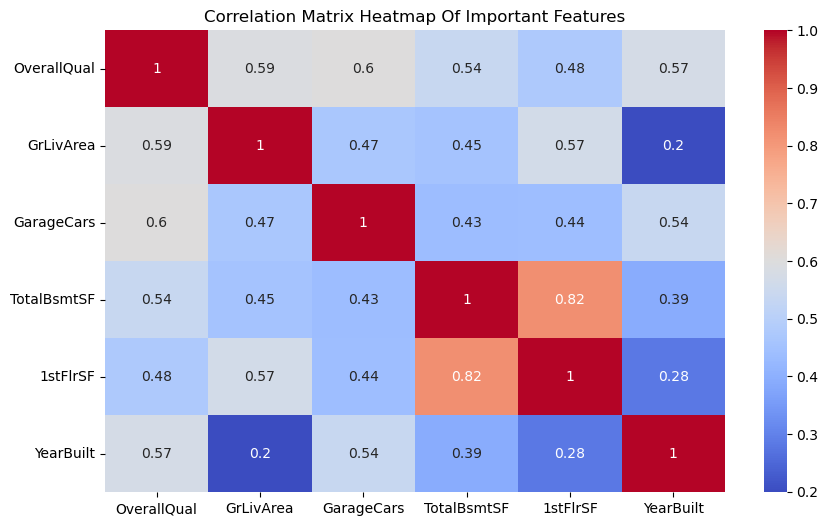

In [4]:
imp_features = train[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','YearBuilt']]
corr = imp_features.corr()

plt.figure(figsize= (10,6))
sns.heatmap(corr, annot = True , cmap = 'coolwarm')
plt.title('Correlation Matrix Heatmap Of Important Features');

In [5]:
num_cols = train.select_dtypes(include = ['int64','float64']).columns
cat_cols = train.select_dtypes(include = ['object']).columns

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

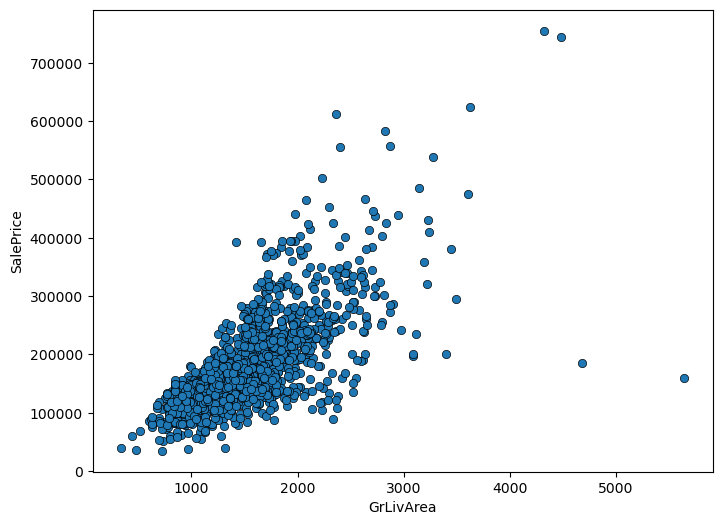

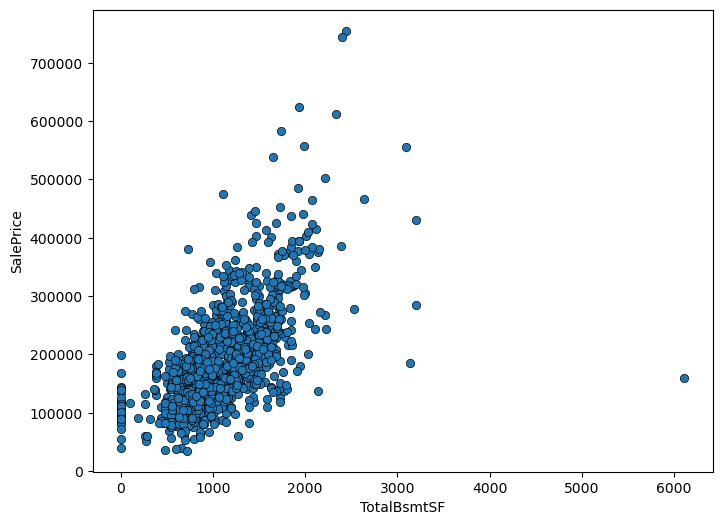

In [6]:
plt.figure(figsize= (8,6))
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice' , data = train, edgecolor = 'black')

plt.figure(figsize= (8,6))
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice' , data = train, edgecolor = 'black')


<Axes: xlabel='OverallQual', ylabel='SalePrice'>

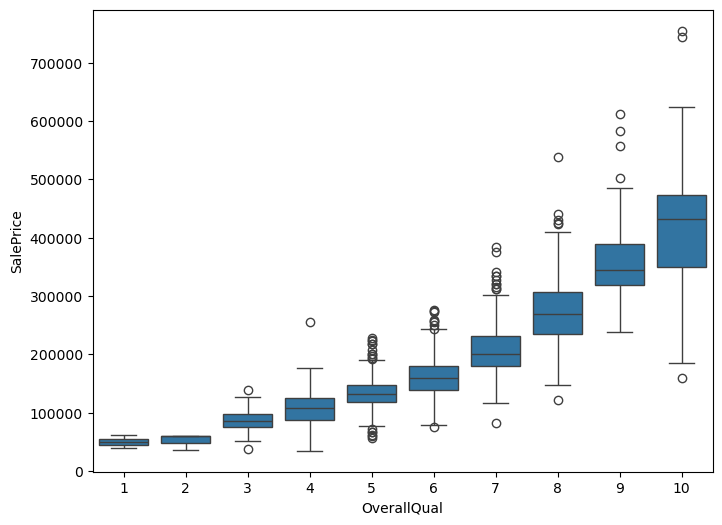

In [7]:
plt.figure(figsize= (8,6))
sns.boxplot(x = 'OverallQual', y = 'SalePrice' , data = train)


In [8]:
filled_num_cols = train[num_cols].fillna(train[num_cols].median())
filled_cat_cols = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])
x = pd.concat([filled_num_cols, filled_cat_cols], axis=1)
final_dataset = pd.concat([x,train['SalePrice']],axis=1)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = final_dataset.select_dtypes(include='object').columns

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

final_dataset_encoded = preprocess.fit_transform(final_dataset)


In [13]:
final_dataset_encoded = final_dataset_encoded.astype(int)


In [18]:
final_dataset_encoded = pd.get_dummies(final_dataset, columns=cat_cols, drop_first=True)


In [19]:
X = final_dataset_encoded.drop(columns=['SalePrice'])
y = final_dataset_encoded['SalePrice']


In [20]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)


In [21]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=3,
    subsample=0.5,
    colsample_bytree=0.6,
)

model.fit(X_train, y_train_log)

# Predictions
y_preds_log = model.predict(X_test)
y_preds = np.expm1(y_preds_log)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print(f"Final RMSE: {rmse:.2f}")


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X_train,y_train,cv = 10 , scoring = 'neg_root_mean_squared_error')
cv_rmse_mean = -np.mean(scores)
cv_rmse_std = -np.std(scores)
print(f"CV RMSE : {cv_rmse_mean:2f}, std: {cv_rmse_std:2f}")
